In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# 指定したファイルパスのcsvファイルを全部読み込む関数
def read_csv_all(target_path = '../input/'):
    for file in glob.glob(target_path+'*.csv'):
        raw_name = 'raw_' + file.replace(target_path,'').replace('.csv','')
        print('read {} as {}'.format(file, raw_name))
        exec('{} = pd.read_csv(\'{}\')'.format(raw_name, file), globals())
        
# trainとtestの加工
def processing_train_test(df):
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

# メモリの節約
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# バイナリ化
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

# 集計用の関数
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [3]:
read_csv_all()

read ../input/new_merchant_transactions.csv as raw_new_merchant_transactions
read ../input/test.csv as raw_test
read ../input/merchants.csv as raw_merchants
read ../input/historical_transactions.csv as raw_historical_transactions
read ../input/train.csv as raw_train
read ../input/sample_submission.csv as raw_sample_submission


In [4]:
raw_historical_transactions['purchase_date'] = pd.to_datetime(raw_historical_transactions['purchase_date'])
raw_new_merchant_transactions['purchase_date'] = pd.to_datetime(raw_new_merchant_transactions['purchase_date'])

In [5]:
train = processing_train_test(raw_train)
test = processing_train_test(raw_test)
target = train['target']
del train['target']

In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


In [7]:
historical_transactions = binarize(raw_historical_transactions)
new_transactions = binarize(raw_new_merchant_transactions)

In [8]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [9]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=[ 'category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

# agg_fun = {'authorized_flag': ['mean']}
# auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
# auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
# auth_mean.reset_index(inplace=True)

# authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
# historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [10]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,month_diff,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,11,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,12,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,12,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,12,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,12,1,0,0,0,0,1,0,0


In [11]:
agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

In [12]:
auth_mean.head()

,card_id,authorized_flag_mean
0,C_ID_00007093c1,0.765101
1,C_ID_0001238066,0.975610
2,C_ID_0001506ef0,0.939394
3,C_ID_0001793786,0.875000
4,C_ID_000183fdda,0.951389


In [13]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [14]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,11.828571
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,11.333333
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,12.000000
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,15.814815
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,11.428571


In [15]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,0.842105,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,11.807018
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,0.708333,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,11.600000
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,11.870968
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,0.000000,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,15.783069
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,0.729927,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,11.751825


In [16]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,12.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,11.500000
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,11.500000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,15.290323
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,11.727273


In [17]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557395,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [19]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [20]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [21]:
# unimportant_features = [
#     'auth_category_2_1.0_mean',
#     'auth_category_2_2.0_mean',
#     'auth_category_2_3.0_mean',
#     'auth_category_2_5.0_mean',
#     'hist_category_2_3.0_mean',
#     'hist_category_2_4.0_mean',
#     'hist_category_2_5.0_mean',
#     'hist_category_3_A_mean',
#     'hist_installments_min',
#     'hist_installments_std',
#     'hist_month_lag_std',
#     'hist_purchase_amount_max',
#     'hist_purchase_month_max',
#     'hist_purchase_month_min',
#     'hist_purchase_month_std',
#     'installments_min_mean',
#     'new_category_2_1.0_mean',
#     'new_category_2_2.0_mean',
#     'new_category_2_3.0_mean',
#     'new_category_2_5.0_mean',
#     'new_city_id_nunique',
#     'new_installments_std',
#     'new_state_id_nunique',
#     'purchase_amount_mean_mean'
# ]
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

In [22]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [23]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71427	valid_1's rmse: 3.77596
[200]	training's rmse: 3.64537	valid_1's rmse: 3.72887
[300]	training's rmse: 3.60167	valid_1's rmse: 3.70576
[400]	training's rmse: 3.57079	valid_1's rmse: 3.69342
[500]	training's rmse: 3.5471	valid_1's rmse: 3.68614
[600]	training's rmse: 3.5282	valid_1's rmse: 3.68135
[700]	training's rmse: 3.51187	valid_1's rmse: 3.67882
[800]	training's rmse: 3.49762	valid_1's rmse: 3.67676
[900]	training's rmse: 3.48459	valid_1's rmse: 3.67522
[1000]	training's rmse: 3.47324	valid_1's rmse: 3.67442
[1100]	training's rmse: 3.46085	valid_1's rmse: 3.67352
[1200]	training's rmse: 3.44928	valid_1's rmse: 3.67351
[1300]	training's rmse: 3.43807	valid_1's rmse: 3.67287
[1400]	training's rmse: 3.42772	valid_1's rmse: 3.6727
[1500]	training's rmse: 3.41746	valid_1's rmse: 3.67269
[1600]	training's rmse: 3.4073	valid_1's rmse: 3.67272
Early stopping, best iteration is:
[1478]	training's r

/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73146	valid_1's rmse: 3.70447
[200]	training's rmse: 3.66161	valid_1's rmse: 3.66108
[300]	training's rmse: 3.61741	valid_1's rmse: 3.64048
[400]	training's rmse: 3.58603	valid_1's rmse: 3.63021
[500]	training's rmse: 3.56239	valid_1's rmse: 3.62456
[600]	training's rmse: 3.54292	valid_1's rmse: 3.62087
[700]	training's rmse: 3.52618	valid_1's rmse: 3.61877
[800]	training's rmse: 3.51137	valid_1's rmse: 3.61714
[900]	training's rmse: 3.49859	valid_1's rmse: 3.61581
[1000]	training's rmse: 3.48595	valid_1's rmse: 3.61508
[1100]	training's rmse: 3.47471	valid_1's rmse: 3.61438
[1200]	training's rmse: 3.46375	valid_1's rmse: 3.61424
[1300]	training's rmse: 3.45322	valid_1's rmse: 3.6138
[1400]	training's rmse: 3.44213	valid_1's rmse: 3.61346
[1500]	training's rmse: 3.43154	valid_1's rmse: 3.61364
[1600]	training's rmse: 3.42102	valid_1's rmse: 3.61356
[1700]	training's rmse: 3.41099	valid_1's rmse: 3.6

/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73559	valid_1's rmse: 3.68013
[200]	training's rmse: 3.66502	valid_1's rmse: 3.63918
[300]	training's rmse: 3.61967	valid_1's rmse: 3.61999
[400]	training's rmse: 3.58838	valid_1's rmse: 3.61063
[500]	training's rmse: 3.56404	valid_1's rmse: 3.60538
[600]	training's rmse: 3.54433	valid_1's rmse: 3.6022
[700]	training's rmse: 3.52789	valid_1's rmse: 3.6
[800]	training's rmse: 3.51299	valid_1's rmse: 3.59846
[900]	training's rmse: 3.49926	valid_1's rmse: 3.59774
[1000]	training's rmse: 3.48701	valid_1's rmse: 3.59699
[1100]	training's rmse: 3.47532	valid_1's rmse: 3.59658
[1200]	training's rmse: 3.46346	valid_1's rmse: 3.5965
[1300]	training's rmse: 3.45259	valid_1's rmse: 3.59629
[1400]	training's rmse: 3.44133	valid_1's rmse: 3.59642
[1500]	training's rmse: 3.43151	valid_1's rmse: 3.59651
Early stopping, best iteration is:
[1310]	training's rmse: 3.45154	valid_1's rmse: 3.59624
fold n°3


/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68745	valid_1's rmse: 3.87974
[200]	training's rmse: 3.61827	valid_1's rmse: 3.83249
[300]	training's rmse: 3.57418	valid_1's rmse: 3.81001
[400]	training's rmse: 3.54212	valid_1's rmse: 3.79774
[500]	training's rmse: 3.51756	valid_1's rmse: 3.79106
[600]	training's rmse: 3.49757	valid_1's rmse: 3.7871
[700]	training's rmse: 3.48128	valid_1's rmse: 3.78445
[800]	training's rmse: 3.46651	valid_1's rmse: 3.78296
[900]	training's rmse: 3.45406	valid_1's rmse: 3.78184
[1000]	training's rmse: 3.44139	valid_1's rmse: 3.78121
[1100]	training's rmse: 3.42918	valid_1's rmse: 3.78069
[1200]	training's rmse: 3.41833	valid_1's rmse: 3.78017
[1300]	training's rmse: 3.40661	valid_1's rmse: 3.77979
[1400]	training's rmse: 3.3955	valid_1's rmse: 3.77956
[1500]	training's rmse: 3.38517	valid_1's rmse: 3.7796
[1600]	training's rmse: 3.37498	valid_1's rmse: 3.77974
Early stopping, best iteration is:
[1458]	training's 

/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/01008968/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73179	valid_1's rmse: 3.69368
[200]	training's rmse: 3.66081	valid_1's rmse: 3.65203
[300]	training's rmse: 3.61598	valid_1's rmse: 3.63347
[400]	training's rmse: 3.58473	valid_1's rmse: 3.62429
[500]	training's rmse: 3.56142	valid_1's rmse: 3.61988
[600]	training's rmse: 3.54278	valid_1's rmse: 3.61703
[700]	training's rmse: 3.52686	valid_1's rmse: 3.61551
[800]	training's rmse: 3.51227	valid_1's rmse: 3.6143
[900]	training's rmse: 3.49935	valid_1's rmse: 3.61344
[1000]	training's rmse: 3.4869	valid_1's rmse: 3.613
[1100]	training's rmse: 3.47398	valid_1's rmse: 3.61282
[1200]	training's rmse: 3.46324	valid_1's rmse: 3.61255
[1300]	training's rmse: 3.45176	valid_1's rmse: 3.61247
[1400]	training's rmse: 3.44117	valid_1's rmse: 3.61266
[1500]	training's rmse: 3.43081	valid_1's rmse: 3.61297
Early stopping, best iteration is:
[1315]	training's rmse: 3.45011	valid_1's rmse: 3.61243
CV score: 3.65542 


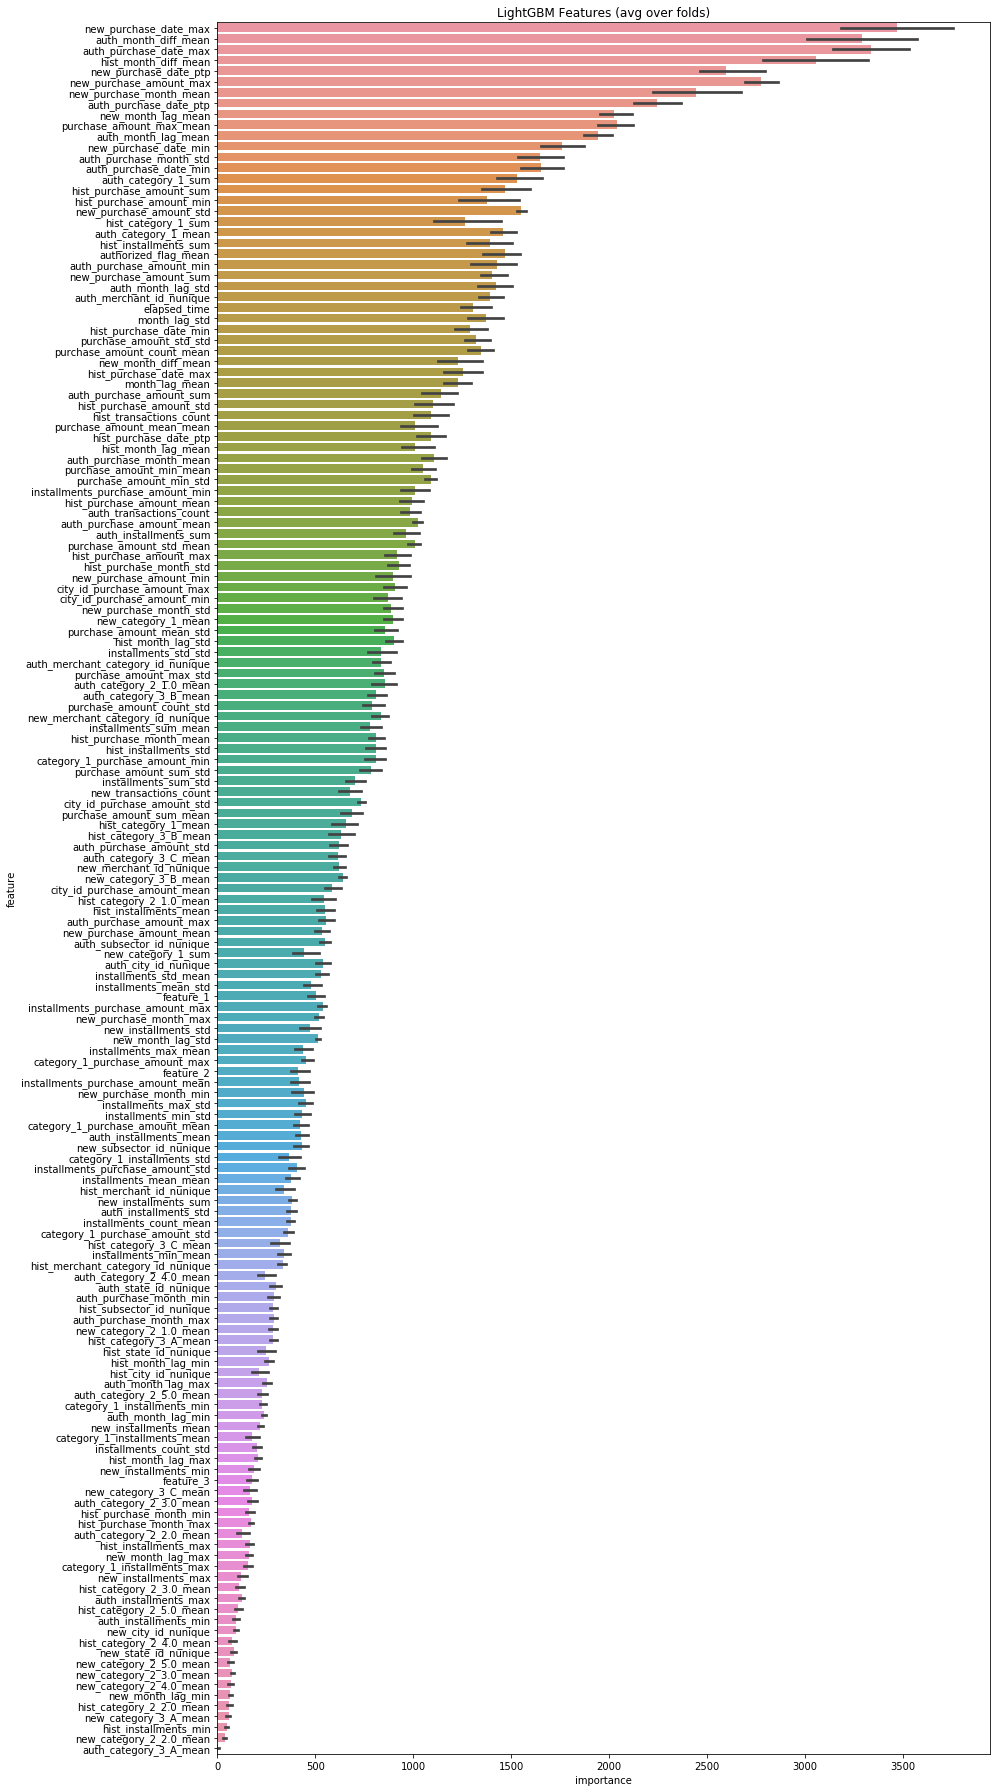

In [27]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('../output/First_Model/lgbm_importances.png')

In [28]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../output/First_Model/submit.csv", index=False)